### Premisa
En este notebook se analizan los pasos seguidos para la creación del modelo RandomForest

---

Carga de librerias

In [ ]:
import pandas as pd
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive
import gdown

Carga de datasets

In [ ]:
# Descargar archivos desde Google Drive
hi_small_id = '1fDw0plQy898cw5aPZ8qBfP61djO6ssDH'
low_small_id = '1LIGRW_huhOGhS1Xl1n-v39R7KweRYMny'
gdown.download(f'https://drive.google.com/uc?export=download&id={hi_small_id}', 'HI-Small_Trans.csv', quiet=False)
gdown.download(f'https://drive.google.com/uc?export=download&id={low_small_id}', 'LI-Small_Trans.csv', quiet=False)

# Cargar los datasets
hi_small = pd.read_csv('HI-Small_Trans.csv')
low_small = pd.read_csv('LI-Small_Trans.csv')

# Descargar los label encoders utilizando gdown
encoders_file_id = '1fi9D8-UYu541eiHGDWugnat1Vavd9a3h'
gdown.download(f'https://drive.google.com/uc?export=download&id={encoders_file_id}', 'label_encoders1.pkl', quiet=False)


Downloading...
From (original): https://drive.google.com/uc?export=download&id=1fDw0plQy898cw5aPZ8qBfP61djO6ssDH
From (redirected): https://drive.google.com/uc?export=download&id=1fDw0plQy898cw5aPZ8qBfP61djO6ssDH&confirm=t&uuid=fbfe4a01-8b65-429b-95cf-815f3ccc3dff
To: /content/HI-Small_Trans.csv
100%|██████████| 476M/476M [00:10<00:00, 45.5MB/s]
Downloading...
From (original): https://drive.google.com/uc?export=download&id=1LIGRW_huhOGhS1Xl1n-v39R7KweRYMny
From (redirected): https://drive.google.com/uc?export=download&id=1LIGRW_huhOGhS1Xl1n-v39R7KweRYMny&confirm=t&uuid=8c6ded90-97b0-4fa3-9c19-09ceb8a3ee3d
To: /content/LI-Small_Trans.csv
100%|██████████| 650M/650M [00:15<00:00, 42.7MB/s]
Downloading...
From: https://drive.google.com/uc?export=download&id=1fi9D8-UYu541eiHGDWugnat1Vavd9a3h
To: /content/label_encoders1.pkl
100%|██████████| 71.7M/71.7M [00:02<00:00, 31.1MB/s]


'label_encoders1.pkl'

Visualización de cantidad de 1s y 0s

In [ ]:
num_ones = low_small['Is Laundering'].value_counts().get(1, 0)
num_zeros = low_small['Is Laundering'].value_counts().get(0, 0)

print(f"Número de 1s: {num_ones}")
print(f"Número de 0s: {num_zeros}")

Número de 1s: 3565
Número de 0s: 6920484


Aplicar los cambios sobre los datos para realizar los labels encoders

In [ ]:
low_small['Timestamp'] = pd.to_datetime(low_small['Timestamp'])

low_small['Year'] = low_small['Timestamp'].dt.year
low_small['Month'] = low_small['Timestamp'].dt.month
low_small['Day'] = low_small['Timestamp'].dt.day
low_small['Hour'] = low_small['Timestamp'].dt.hour
low_small['Minute'] = low_small['Timestamp'].dt.minute

low_small.drop(columns=['Timestamp'], inplace=True)
low_small.rename(columns={'Account': 'Account2', 'Account.1': 'Account4'}, inplace=True)

Aplicación de los labels encoders

In [ ]:

with open('label_encoders1.pkl', 'rb') as file:
    label_encoders = pickle.load(file)

for col, le in label_encoders.items():
    if col in low_small.columns:
        low_small[col] = le.transform(low_small[col])

Se realiza un proceso de submuestreo para balancear las clases en el dataset. El objetivo es lograr una distribución del 70% de no fraudes (clase 0) y un 30% de fraudes (clase 1) en el dataset.

In [ ]:
fraudes = low_small[low_small['Is Laundering'] == 1]
no_fraudes = low_small[low_small['Is Laundering'] == 0]

num_zeros_requeridos = int(len(fraudes) * (70 / 30))
no_fraudes_submuestreado = no_fraudes.sample(n=num_zeros_requeridos, random_state=42)
low_small_balanceado = pd.concat([fraudes, no_fraudes_submuestreado])

low_small = low_small_balanceado.sample(frac=1, random_state=42).reset_index(drop=True)
low_small = low_small_balanceado.copy()

Se está realizando la división de los datos en tres conjuntos: entrenamiento, validación y prueba.
60% de entrenamiento, 20% de validación y 20% de prueba

In [ ]:
X = low_small.drop('Is Laundering', axis=1)
y = low_small['Is Laundering']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.40, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42)

Creación del modelo RandomForest

In [ ]:
model = RandomForestClassifier(class_weight={0: 1, 1: 10}, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(class_weight={0: 1, 1: 10}, random_state=42)

Validación

In [ ]:
y_val_pred = model.predict(X_val)

print("Reporte de clasificación en el conjunto de validación:")
print(classification_report(y_val, y_val_pred))

Reporte de clasificación en el conjunto de validación:
              precision    recall  f1-score   support

           0       0.90      0.93      0.91      1637
           1       0.83      0.78      0.80       740

    accuracy                           0.88      2377
   macro avg       0.86      0.85      0.86      2377
weighted avg       0.88      0.88      0.88      2377



Test

In [ ]:
y_pred = model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
print("Matriz de Confusión:")
print(cm)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Matriz de Confusión:
[[1513  155]
 [ 180  529]]
Accuracy: 0.8590660496424064
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.91      0.90      1668
           1       0.77      0.75      0.76       709

    accuracy                           0.86      2377
   macro avg       0.83      0.83      0.83      2377
weighted avg       0.86      0.86      0.86      2377



---

## Ajuste de umbrales

Primera prueba de umbral de 0,2

Accuracy with adjusted threshold: 0.856541859486748
Classification Report with adjusted threshold:
               precision    recall  f1-score   support

           0       0.98      0.81      0.89      1668
           1       0.68      0.97      0.80       709

    accuracy                           0.86      2377
   macro avg       0.83      0.89      0.84      2377
weighted avg       0.89      0.86      0.86      2377



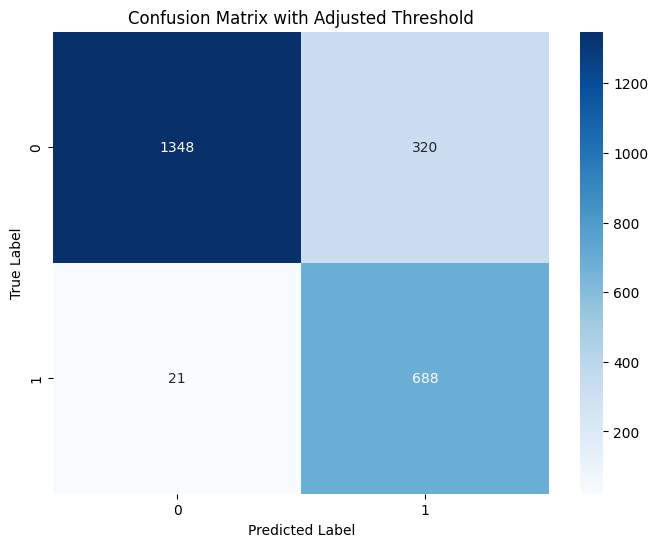

In [ ]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix


y_probs = model.predict_proba(X_test)[:, 1]

threshold = 0.2
y_pred_adjusted = (y_probs >= threshold).astype(int)

print("Accuracy with adjusted threshold:", accuracy_score(y_test, y_pred_adjusted))
print("Classification Report with adjusted threshold:\n", classification_report(y_test, y_pred_adjusted))

conf_matrix = confusion_matrix(y_test, y_pred_adjusted)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix with Adjusted Threshold')
plt.show()

## Ajuste de pesos

Accuracy with class weights: 0.8582246529238536
Classification Report with class weights:
               precision    recall  f1-score   support

           0       0.89      0.91      0.90      1668
           1       0.77      0.74      0.76       709

    accuracy                           0.86      2377
   macro avg       0.83      0.82      0.83      2377
weighted avg       0.86      0.86      0.86      2377



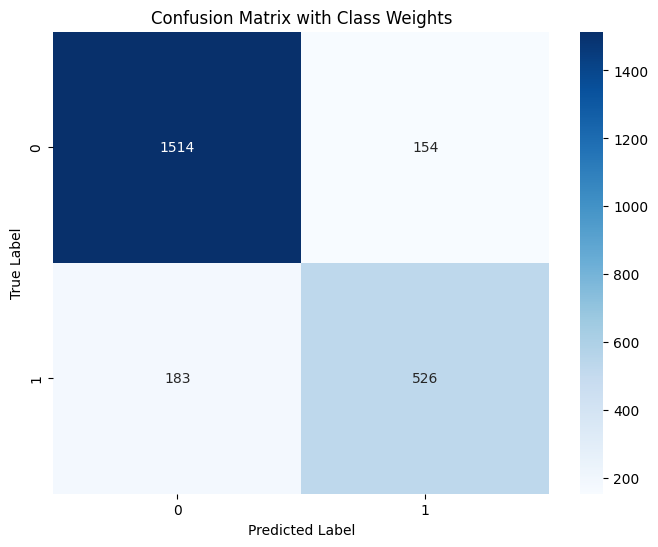

In [ ]:
model_weighted = RandomForestClassifier(class_weight={0: 1, 1: 20}, random_state=42)

model_weighted.fit(X_train, y_train)
y_pred_weighted = model_weighted.predict(X_test)

print("Accuracy with class weights:", accuracy_score(y_test, y_pred_weighted))
print("Classification Report with class weights:\n", classification_report(y_test, y_pred_weighted))

conf_matrix_weighted = confusion_matrix(y_test, y_pred_weighted)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_weighted, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix with Class Weights')
plt.show()

## Prueba combinada de umbral y peso

Umbral de 0,25 y peso ajustado anteriormente

Accuracy with adjusted threshold: 0.8624316365166176
Classification Report with adjusted threshold:
               precision    recall  f1-score   support

           0       0.98      0.82      0.89      1668
           1       0.70      0.95      0.80       709

    accuracy                           0.86      2377
   macro avg       0.84      0.89      0.85      2377
weighted avg       0.89      0.86      0.87      2377



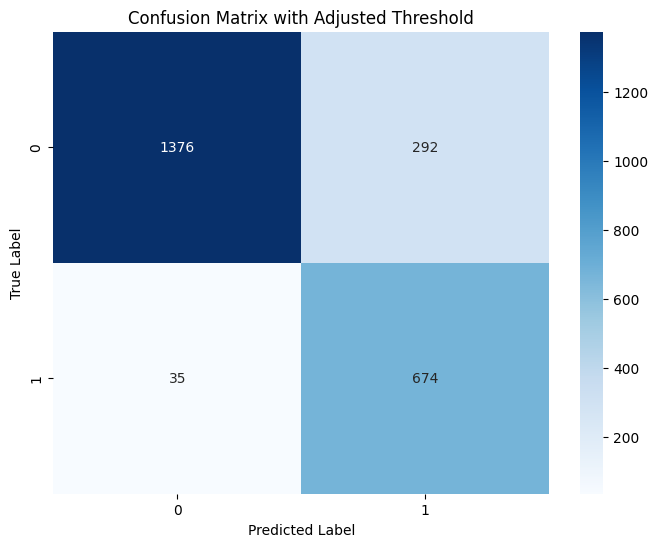

In [ ]:
y_probs = model_weighted.predict_proba(X_test)[:, 1]
threshold = 0.25

y_pred_adjusted = (y_probs >= threshold).astype(int)
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print("Accuracy with adjusted threshold:", accuracy_score(y_test, y_pred_adjusted))
print("Classification Report with adjusted threshold:\n", classification_report(y_test, y_pred_adjusted))

conf_matrix_adjusted = confusion_matrix(y_test, y_pred_adjusted)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_adjusted, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix with Adjusted Threshold')
plt.show()

Umbral de 0,15 y un peso con valor 30 a la clase 1

Accuracy with adjusted class weights and threshold: 0.8527555742532604
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.80      0.88      1668
           1       0.68      0.98      0.80       709

    accuracy                           0.85      2377
   macro avg       0.83      0.89      0.84      2377
weighted avg       0.89      0.85      0.86      2377



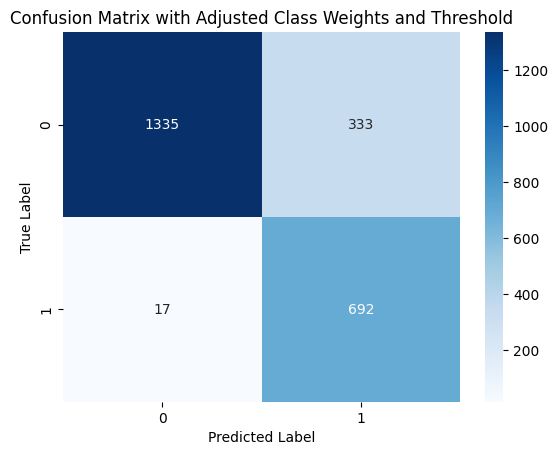

In [ ]:
model_weighted_30 = RandomForestClassifier(class_weight={0: 1, 1: 30}, random_state=42)
model_weighted_30.fit(X_train, y_train)

y_probs_weighted = model_weighted_30.predict_proba(X_test)[:, 1]
threshold = 0.15
y_pred_adjusted_weighted = (y_probs_weighted >= threshold).astype(int)

print("Accuracy with adjusted class weights and threshold:", accuracy_score(y_test, y_pred_adjusted_weighted))
print("Classification Report:\n", classification_report(y_test, y_pred_adjusted_weighted))

conf_matrix_weighted = confusion_matrix(y_test, y_pred_adjusted_weighted)
sns.heatmap(conf_matrix_weighted, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix with Adjusted Class Weights and Threshold')
plt.show()

---

# Prueba sobre el dataset HI Small

Preparación de datos para aplicar los label encoders

In [ ]:
hi_small['Timestamp'] = pd.to_datetime(hi_small['Timestamp'])

hi_small['Year'] = hi_small['Timestamp'].dt.year
hi_small['Month'] = hi_small['Timestamp'].dt.month
hi_small['Day'] = hi_small['Timestamp'].dt.day
hi_small['Hour'] = hi_small['Timestamp'].dt.hour
hi_small['Minute'] = hi_small['Timestamp'].dt.minute

hi_small.drop(columns=['Timestamp'], inplace=True)
hi_small.rename(columns={'Account': 'Account2', 'Account.1': 'Account4'}, inplace=True)

In [ ]:
for col, le in label_encoders.items():
    if col in hi_small.columns:
        hi_small[col] = le.transform(hi_small[col])

X_hi = hi_small.drop('Is Laundering', axis=1)
y_hi = hi_small['Is Laundering']

Prueba del modelo RandomForest sobre el dataset Hi-Small

In [ ]:
y_hi_pred = model_weighted_30.predict(X_hi)


print("Accuracy on HI-Small:", accuracy_score(y_hi, y_hi_pred))
print("Classification Report on HI-Small:\n", classification_report(y_hi, y_hi_pred))

conf_matrix_hi = confusion_matrix(y_hi, y_hi_pred)
print("Matriz de Confusión:\n", conf_matrix_hi)

Accuracy on HI-Small: 0.9166238213433707
Classification Report on HI-Small:
               precision    recall  f1-score   support

           0       1.00      0.92      0.96   5073168
           1       0.01      0.80      0.02      5177

    accuracy                           0.92   5078345
   macro avg       0.50      0.86      0.49   5078345
weighted avg       1.00      0.92      0.96   5078345

Matriz de Confusión:
 [[4650807  422361]
 [   1052    4125]]
